In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "~/datasets/brainmap/paired/0/T1.nii.gz"

img = nib.load(example_filename)
OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape

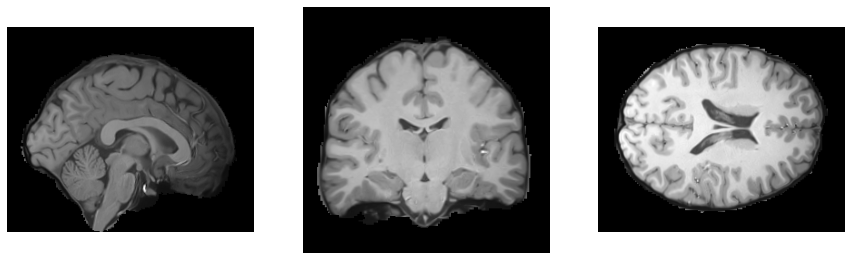

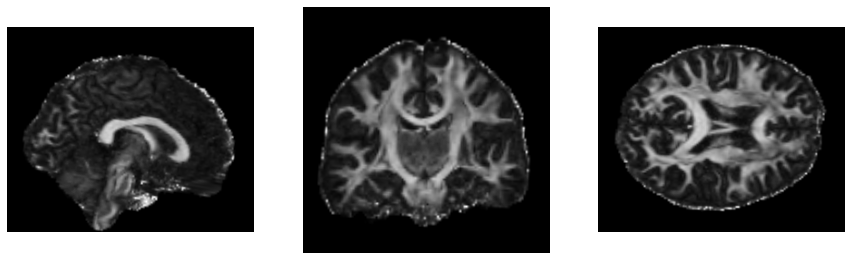

In [2]:
### units for data preprocession
from units.dataloader import load_pair
from units.base import visualize

t1,fa=load_pair(r"./datasets/brainmap/paired/9")
# t1[fa==0]=0
visualize(t1)
visualize(fa)

In [3]:
%cd ..

c:\Users\CH2\Projects\AD_GAN


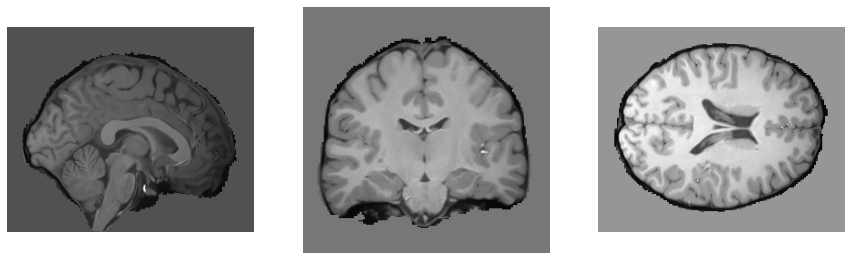

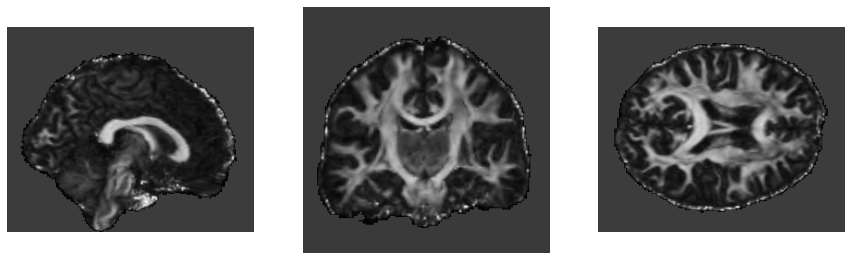

In [3]:
### visualize argument
from units.prep import random_jitter
for i in range(1):
    t1_arg,fa_arg=t1,fa#Patch_extration()(t1,fa)
    t1_arg,fa_arg=random_jitter(t1_arg,fa_arg)#,[Rotation3D(max_rate=np.pi/2)])
    visualize(t1_arg)
    visualize(fa_arg)

In [3]:
### input pipeline
# class DataGenerator(tf.keras.utils.Sequence):
#     '''data generator'''
#     def __init__(self,datalist:list,batchsize=4,):
#     def __len__(self):
#         pass
#     def __getitem__(self,idx):
#         pass
%cd ..

c:\Users\CH2\Projects\AD_GAN


In [4]:
### train_test_split
PATH = "./datasets/brainmap/paired"
data=[f"{PATH}/{imgdir}"for imgdir in os.listdir(PATH)]
# print(data)
from sklearn.model_selection import train_test_split
train_val,test=train_test_split(
    data,test_size=0.1,random_state=1919810
)
train,val=train_test_split(
    train_val,test_size=0.1,random_state=114514
)
# train
print(f"Train len: {len(train)}")
print(f"Val len: {len(val)}")
print(f"Test len: {len(test)}")

Train len: 16
Val len: 2
Test len: 2


In [9]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
from units.dataloader import load_image_train,load_image_test
# print(f"train_dataset: {len(train_dataset)}")
train_dataset = list(map(load_image_train,train))
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = list(map(load_image_test,test))
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result